# Trading with Deep Learning
### Automated Stock Selection with Keras
#### Kyle Stahl
#### March 2018

## __Introduction__

Some days stocks go up, and other days stocks go down. The idea of this analysis is to take advantage of when stocks go up, and hopefully not be invested when they go down. At the beginning of each day we buy stocks that are predicted to increase in value, and at the end of every day we sell off the whole portfolio. Then rinse and repeat.

We will use a deep learning technique called Long Short Term Memory (LSTM) which will try to find the nuanced patterns in the daily stock returns. It will not be perfect, but hopefully it can be a little better than just investing in a market index. I randomly picked a few stocks of companies that people generally know about and have data going back to 1990.

This is mostly just a proof of concept. The end goal is to incorperate this with my stock portfolio optimizer that can be found here: [www.kyle-stahl-mn.com/stock-portfolio-optimization/](www.kyle-stahl-mn.com/stock-portfolio-optimization/).

Some assumptions are made to make the analysis run smoother. First we assume that we can buy factions of stock (in practice this could be true if someone made a derivative like that), most everyday people do not have that ability. Second this analysis assumes that you can buy stocks at the beginning of one day at the closing price of the previous day, which is almost never true because things will happen over night that can affect prices. Also, the fact that you buy a few stocks can push the price up. These two things, even though slightly unrealistic, make this analysis much easier.

### __Import Packages__

In [1]:
import numpy as np
import pandas as pd

# tqdm is used to track the progress of loops
from tqdm import tqdm

import keras
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import LSTM, RNN
from keras import backend as K

import quandl
quandl.ApiConfig.api_key = "

Using TensorFlow backend.


I used the quandl API to get the stock market data. All you need to do to use it is get a key from https://www.quandl.com/tools/python. You can also get stock market prices fairly easily from pandas-datareader, yahoo finance, and google finance. 

### __Download Stock Data__

Here we define a list of a bunch of stock tickers to pick from to put in our portfolio. I used the same list from a previous analysis, but subsetted it based on stocks that have data going back to 1990.

In [2]:
stocks = ['AAPL','F','MSFT','GIS',
          'DIS','BBY','BA','EFX','GE',
          'HON','IBM','JNJ','NKE',
          'TGT','USB','VZ','WFC']

num_stocks = len(stocks)
stock_prices = pd.DataFrame()

Then we loop through that list, the grab the stock prices from 1990, and append those prices to a data frame. 

In [3]:
for stock in stocks:
    #print(stock)
    new_stock = quandl.get('WIKI/'+stock,
    start_date="1990-01-01")['Adj. Close']
    stock_prices[stock] = new_stock

In [4]:
stock_prices.head(5)

,AAPL,F,MSFT,GIS,DIS,BBY,BA,EFX,GE,HON,IBM,JNJ,NKE,TGT,USB,VZ,WFC
Date,,,,,,,,,,,,,,,,,
1990-01-02,1.118093,3.037534,0.410278,3.379412,7.202258,0.174376,11.542708,3.244748,2.537067,4.628237,14.138144,3.993355,0.625343,3.371228,0.744327,7.370820,1.307096
1990-01-03,1.125597,3.054316,0.412590,3.384967,7.217847,0.195301,11.824237,3.269268,2.532126,4.643935,14.263656,4.009361,0.611446,3.403444,0.722708,7.354656,1.249311
1990-01-04,1.129499,3.054316,0.424702,3.387282,7.209741,0.191953,11.777316,3.293787,2.518063,4.790448,14.426678,4.018030,0.598995,3.409679,0.722708,7.142583,1.235442
1990-01-05,1.133101,3.012025,0.414300,3.340638,7.233437,0.191953,11.614029,3.269268,2.494118,4.855856,14.390611,3.976016,0.617005,3.416434,0.705942,6.979317,1.199038
1990-01-08,1.140605,3.012025,0.420680,3.335041,7.295170,0.177724,11.752916,3.218185,2.508561,4.855856,14.480057,4.042705,0.614226,3.449169,0.694911,7.061930,1.235442


### __Get Percent Change in Price__

Next we are going to find the percent change in price for each stock on each day. I orignally used returns, but I found that having the values between -1 and 1 were easier to predict. Therefore I used the percent change instead.

*__For day i...__*
$$Return_i = \frac{Price_i}{Price_{i-1}} \qquad \qquad Pct. Change = \frac{Price_i - Price_{i-1}}{Price_{i-1}}
\qquad \Rightarrow \qquad Return_i = Pct. Change + 1$$

In [5]:
returns = stock_prices.pct_change()
returns = returns.iloc[1:] # Day 1 does not have a return so we remove it from the dataframe
#returns = returns + 1
returns.head(5)

,AAPL,F,MSFT,GIS,DIS,BBY,BA,EFX,GE,HON,IBM,JNJ,NKE,TGT,USB,VZ,WFC
Date,,,,,,,,,,,,,,,,,
1990-01-03,0.006711,0.005525,0.005634,0.001644,0.002165,0.120000,0.024390,0.007557,-0.001948,0.003392,0.008878,0.004008,-0.022222,0.009556,-0.029046,-0.002193,-0.044209
1990-01-04,0.003467,0.000000,0.029356,0.000684,-0.001123,-0.017143,-0.003968,0.007500,-0.005554,0.031549,0.011429,0.002162,-0.020364,0.001832,0.000000,-0.028835,-0.011101
1990-01-05,0.003189,-0.013846,-0.024491,-0.013770,0.003287,0.000000,-0.013865,-0.007444,-0.009509,0.013654,-0.002500,-0.010456,0.030067,0.001981,-0.023199,-0.022858,-0.029467
1990-01-08,0.006623,0.000000,0.015398,-0.001676,0.008534,-0.074128,0.011959,-0.015625,0.005791,0.000000,0.006216,0.016773,-0.004505,0.009582,-0.015625,0.011837,0.030361
1990-01-09,-0.009737,-0.016715,-0.002747,-0.005315,-0.001027,0.000000,-0.011817,0.023492,-0.020909,-0.019935,-0.009963,-0.030848,-0.018100,-0.013257,0.000000,-0.027842,-0.029467


### __Explore Mean and Standard Deviation__

**Daily Returns**

In [6]:
pd.DataFrame(index=returns.columns, 
             data={'Mean':returns.mean(axis='index'),
                   'St.dev.':returns.std()})


,Mean,St.dev.
AAPL,0.001123,0.028257
F,0.000473,0.024360
MSFT,0.000969,0.020185
GIS,0.000459,0.012189
DIS,0.000549,0.018630
BBY,0.001398,0.032923
BA,0.000652,0.018731
EFX,0.000693,0.018947
GE,0.000398,0.017541
HON,0.000675,0.019173


In [7]:
test_year = '2005-01-01'
train = returns[returns.index < test_year]
test = returns[returns.index >= test_year]

**Compare Mean and Std of Return in the train and test**

Things change over time. Here we see the average annual return on the test set is slightly smaller, but the standard deviation of all the annual returns is also smaller. I split training-testing data in 2005; that way I would have a market crash (in 2000 and the other in 2008) in both the train and test set.

In [8]:
train_annual = stock_prices[stock_prices.index < test_year].groupby(pd.Grouper(freq='A')).first().pct_change().dropna() +1
test_annual  = stock_prices[stock_prices.index >= test_year].groupby(pd.Grouper(freq='A')).first().pct_change().dropna() +1

print('Train average return: {}'.format(np.round(train_annual.mean().mean(),3)))
print('Test  average return: {}'.format(np.round(test_annual.mean().mean(),3)))
print('Train average standard deviation of return: {}'.format(np.round(train_annual.mean().std(),3)))
print('Test  average standard deviation of return: {}'.format(np.round(test_annual.mean().std(),3)))

Train average return: 1.24
Test  average return: 1.147
Train average standard deviation of return: 0.176
Test  average standard deviation of return: 0.097


### __Create Target Variable (tomorrows return)__

In [9]:
Ytrain = train.iloc[1:,].as_matrix()
Xtrain = train.iloc[:-1,].as_matrix()

Ytest = test.iloc[1:,].as_matrix()
Xtest = test.iloc[:-1,].as_matrix()

We need to change the shape and dimensions of the training data because Keras is picky and expecting input only in this shape :)

In [10]:
Xtrain = Xtrain.reshape(Xtrain.shape[0],-1,1)
Xtest = Xtest.reshape(Xtest.shape[0],-1,1)

In [11]:
print(Xtrain.shape)
print(Ytrain.shape)

(3782, 17, 1)
(3782, 17)


### __Build and Train Model__

In [12]:
model = Sequential()
model.add(LSTM(num_stocks,
               stateful=True,
               batch_input_shape=(1,num_stocks,1),
               activation='tanh'))

model.add(Dense(num_stocks, activation='tanh'))

model.compile(loss='mean_absolute_error', optimizer='adam')
model.fit(Xtrain, Ytrain, epochs=1, batch_size=1, verbose=2)

Epoch 1/1
 - 121s - loss: 0.0158


In [13]:
model.predict(Xtest[200].reshape(1,num_stocks,1))

array([[-0.00325414, -0.00079721, -0.00222504, -0.00056235, -0.00115434,
        -0.00452787, -0.00230824, -0.00118234,  0.00066326, -0.00138735,
        -0.00377189,  0.00189747, -0.00092842,  0.00046581,  0.00124883,
         0.00236648,  0.00165176]], dtype=float32)

### __Test the Trading Strategy__

Here we step through each day. At the beggining of each day we calculate our predicted percent changes for each stock, and then we choose to purchase the stocks that have a positive daily return of more than 0.05%. Next we calculate how much money we made (or lost). After that, we train the model with the new days worth of stock prices and move on to tomorrow. 

In [14]:
picked_stocks = np.zeros([Xtest.shape[0],num_stocks])
portfolio_value = np.zeros(Xtest.shape[0])

money = 100000.0

In [15]:
# Loop through Time periods in test set
for i in tqdm(np.arange(Xtest.shape[0])):
    
    # Save Portfolio Value at time i
    portfolio_value[i] = money
    
    # Select Stocks
    picked_stocks[i] = (model.predict(Xtest[i].reshape(1,num_stocks,1)) > 0.0005).astype(int)
    
    # Invest equally across stocks predicted to increase
    investment = picked_stocks[i] * (money / picked_stocks[i].sum())
    
    # Adjust investment value by actual returns on that day
    investment *= (Ytest[i] + 1)
    
    # Update total dollar amount
    if investment.sum() > 0: # Catch if you did not invest anything
        money = investment.sum()
    
    # Train model with new observation
    model.train_on_batch(Xtest[i].reshape(1,num_stocks,1),Ytest[i].reshape(1,num_stocks))

  0%|▏                                                                                | 6/3318 [00:00<03:01, 18.20it/s]C:\Users\kyles\.conda\envs\Python3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\kyles\.conda\envs\Python3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in multiply
  # This is added back by InteractiveShellApp.init_path()
100%|██████████████████████████████████████████████████████████████████████████████| 3318/3318 [02:39<00:00, 19.27it/s]


### __Get Market Index NASDAQ Performance__

I compared the LSTM performance to the NASDAQ composite index taken from Quandl. Here we get the prices for the test set and figure out how many shares we can buy on January 1st, then we track the value of those shares over the whole duration of the test set.

In [16]:
# Get Market Index
Market = quandl.get("NASDAQOMX/COMP", start_date=test_year)["Index Value"]

# Invest $100,000 on Jan. 1st 2017
market_shares = 100000 / Market.iloc[0,]
market_overall = Market * market_shares

In [17]:
# Filter results of market that are in test set
market_overall = market_overall[np.in1d(market_overall.index, test.index)]

### __Compare Results__

In [18]:
results = pd.DataFrame(index=market_overall.index,
                       data = {'LSTM':portfolio_value[:-3],
                               'Market Index': market_overall})

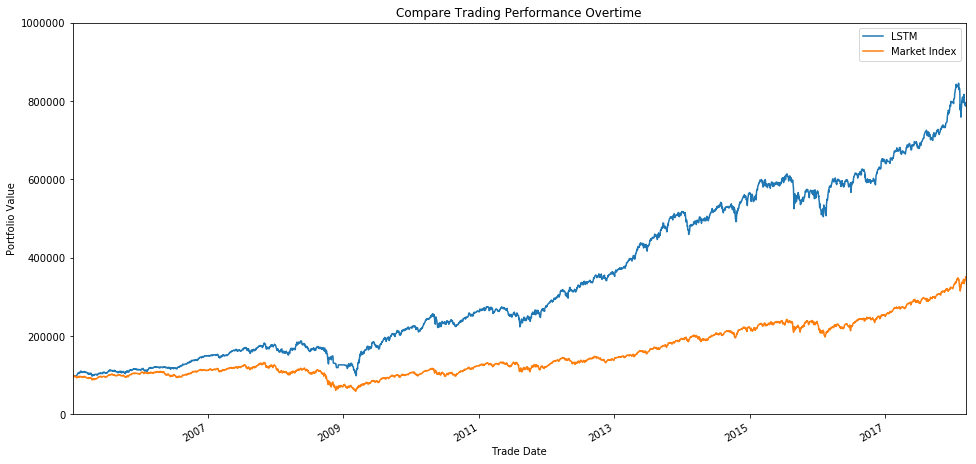

In [19]:
#Plot Results
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [16,8]

results.plot(kind='line',ylim=(0,1000000),title='Compare Trading Performance Overtime').set_ylabel('Portfolio Value')

**Find Average Annual Return**

In [20]:
annual = results.groupby(pd.Grouper(freq='A')).first()
annual_returns = annual.pct_change().dropna() + 1
annual_returns

,LSTM,Market Index
Trade Date,,
2006-12-31,1.127708,1.042557
2007-12-31,1.326740,1.079965
2008-12-31,1.172580,1.076953
2009-12-31,0.720503,0.625456
2010-12-31,1.756603,1.414291
2011-12-31,1.179377,1.165958
2012-12-31,1.058182,0.984098
2013-12-31,1.270798,1.175005
2014-12-31,1.466588,1.331209


In [21]:
annual_returns.mean().round(2)

LSTM            1.20
Market Index    1.11
dtype: float64

### __Analysis of which stocks were choosen__

Here we want to look at how often each stock is getting chosen to be invested in. We find the total amount of times that each stock is chosen in each year, then plot it over all years in the test set. It is a good sign to see that one stock doesn't dominate the portfolio over time. It is also interesting to see how every stock, except for General Mills, was purchased less in 2008, so the model picked up on the fact that it should not be investing as much when the market is going down. 

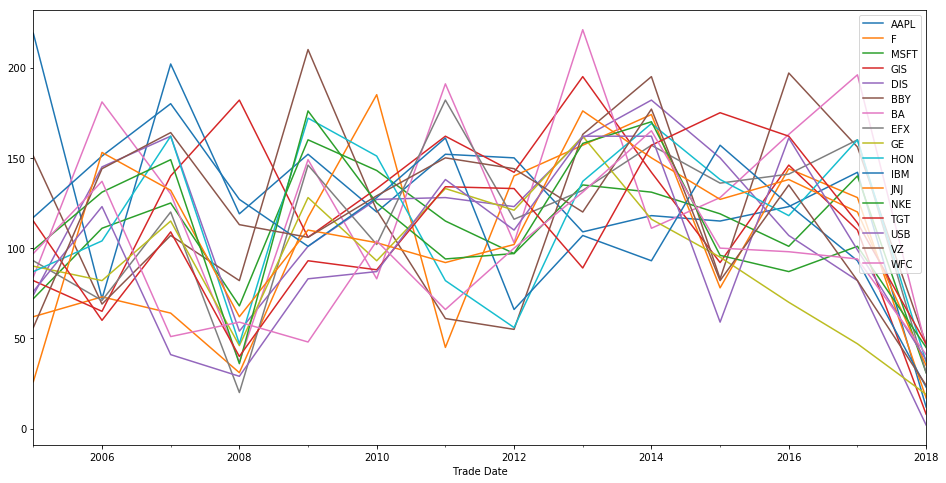

In [22]:
pd.DataFrame(index = market_overall.index,
             data  = picked_stocks[:-3,:],
             columns = returns.columns).groupby(pd.Grouper(freq='A')).sum().plot()

### __Future Analysis and Next Steps__

This analysis gave great signs that a this method could be used to pick stocks to invest in each day, week, month, etc. Any vanilla investing strategy using the stocks I was investigating with would've given their average annual return of 14.7% and beat the NASDAQ index. This model showed a 5.3% improvement upon that with an average annual return of 20% over the 13 year period.

As mentioned above, this is just a proof of concept and a lot more can be done to make this a better model. This strategy should be tested with many more stocks, over different periods of time, and possibly at the weekly level (instead of trading every single day).

There is also room for improvement by finding the optimal combination of stocks that will minimize the variance of the portfolio each day, opposed to allocating the same amount to every stock. 